In [2]:
'''ResNet in PyTorch.

For Pre-activation ResNet, see 'preact_resnet.py'.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, prob_dropout=0.3):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        # mod here
        self.dropout1 = nn.Dropout2d(p=prob_dropout)
        
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        

        # mod here
        self.dropout2 = nn.Dropout2d(p=prob_dropout)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [4]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [5]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


In [6]:
def ResNet9():
    return ResNet(BasicBlock, [1, 1, 1, 1])
    
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


# def ResNet34():
#     return ResNet(BasicBlock, [3, 4, 6, 3])


# def ResNet50():
#     return ResNet(Bottleneck, [3, 4, 6, 3])


# def ResNet101():
#     return ResNet(Bottleneck, [3, 4, 23, 3])


# def ResNet152():
#     return ResNet(Bottleneck, [3, 8, 36, 3])


# def test():
#     net = ResNet18()
#     y = net(torch.randn(1, 3, 32, 32))
#     print(y.size())

# test()

print("done")

done


In [7]:
from torchvision import transforms, datasets
import torch.utils.data
from torchvision.transforms import ToTensor


In [8]:
torch.manual_seed(1024)
# Define transformations to be applied on the training dataset
train_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), # Add color jitter
    transforms.RandomHorizontalFlip(), #apply horizontal flipping
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(), # Randomly flip the images on the horizontal axis
    transforms.RandomRotation(10), # Randomly rotate the images by +/- 10 degrees
    transforms.RandomCrop(32, padding=4), # Apply random crops
    transforms.ToTensor(), # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # Normalize images
])

# Define transformations to be applied on the testing dataset 
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Import the datasets and transform it
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# Define the batch size for training
batch_size = 16

# Create DataLoader
trainDataLoader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testDataLoader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# for batch in train_loader:
#     print(batch)
print("done")

Files already downloaded and verified
Files already downloaded and verified
done


In [9]:
# Import all the necessary libraries

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pickle
from PIL import Image
import matplotlib.pyplot as plt

# Set a manual seed for reproducibility
torch.manual_seed(1024)

In [10]:
# Function used to calculate the accuracy on the cifar_no_labels dataset
def calculate_accuracy(predictions):
    actual = []
    pattern = [8, 2, 9, 0, 4, 3, 6, 1, 7, 5]
    for num in pattern:
        actual.extend([num] * 1000)
    num_matches = sum(1 for pred, act in zip(predictions, actual) if pred == act)
    accuracy = (num_matches / len(predictions)) * 100
    return accuracy

In [11]:
# Function to load and transform the cifar_no_labels dataset 
def load_kaggle_data(file, transform=None):
    import pickle
    with open(file, 'rb') as fo:
        batch = pickle.load(fo, encoding='bytes')
    images = batch[b'data']
    images = images.reshape((-1, 3, 32, 32)).transpose(0, 2, 3, 1)
    min_val = np.min(images)
    max_val = np.max(images)
    images = (images - min_val) / (max_val - min_val) #normalizing facepalm
    processed_images=[]
    for i,image in enumerate(images):
        pil_image = Image.fromarray((image * 255).astype(np.uint8))
        # Apply transformation
        pil_image = transform(pil_image)
        
        # Append transformed image
        processed_images.append(pil_image)
    return processed_images

In [12]:
# Tranformation to be applied on the cifar_test_nolabels.pkl dataset
kaggle_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Loading the cifar_test_nolabels images and transforming as needed
test_images = load_kaggle_data('kaggle/cifar_test_nolabels.pkl', transform=kaggle_transform)
kaggleLoader = torch.utils.data.DataLoader(test_images, batch_size=1,shuffle=False)
print(len(kaggleLoader))

10000


In [13]:
import torch.optim.lr_scheduler as lr_scheduler

# Initialize empty lists to store training and test loss history
train_loss_history = []
test_loss_history = []
train_accuracy_history = []
test_accuracy_history = []

no_label_accuracy_history = []

# Initialize variables to track accuracy
matches = 0
total = 0

# Initialize the best Kaggle accuracy and learning rate
best_kagg_acc = 0.0
lr_best = -1

# Define a list of learning rates to try (commented out for now)
# lr_arr = [.003, .005, 0.0001, 0.0005, 0.0002, 0.0003, 0.0004, 0.005, 0.008]

# Iterate through the learning rates (commented out for now)
# for learn_rate in lr_arr[:2]:

# Set the learning rate (using a fixed value for now)
learn_rate = .004

In [14]:
# Set the number of training epochs
num_epochs = 60

In [15]:
# Initialize model, loss function, optimizer, and learning rate scheduler
model = ResNet9().cuda() # .cuda to train on the GPU
loss = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=learn_rate, momentum=0.9, weight_decay=1e-5)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)  # T_max is typically set to the number of epochs

In [16]:
# Print a message to indicate the start of the training loop
print("Beginning training arc now!~~~ \n")

for epoch in range(num_epochs):
    train_loss = 0.0
    test_loss = 0.0
    train_acc = 0.0
    test_acc = 0.0

    model.train()
    for i, data in enumerate(trainDataLoader):
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        optimizer.zero_grad() # zero out any gradient values from the previous iteration
        predicted_output = model(images) # forward propagation
        fit = loss(predicted_output, labels)  # calculate our measure of goodness
        fit.backward() # backpropagation
        optimizer.step() # update the weights of our trainable parameters
        train_loss += fit.item()
        _, predicted = torch.max(predicted_output.data, 1)
        train_acc += (predicted == labels).sum().item()
        
    scheduler.step()
    for i, data in  enumerate(testDataLoader):
        with torch.no_grad():
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            predicted_output = model(images)
            fit = loss(predicted_output, labels)
            test_loss += fit.item()
            _, predicted = torch.max(predicted_output.data, 1)
            matches += (predicted == labels).sum().item()
            total += labels.size(0)
            test_acc += (predicted == labels).sum().item()
    train_loss = train_loss / len(trainDataLoader)
    test_loss = test_loss / len(testDataLoader)
    train_acc = train_acc / len(trainDataLoader.dataset)
    test_acc = test_acc / len(testDataLoader.dataset)
    train_loss_history += [train_loss]
    test_loss_history += [test_loss]
    train_accuracy_history += [train_acc]
    test_accuracy_history += [test_acc]

    predictions = []
    # model.eval()
    # Saving the best model if it exceeds the previous best accuracy
    for image in kaggleLoader:
        image = image.cuda()
        with torch.no_grad():
            output = model(image)
        predictions.append(output.argmax().item())
    curr_acc = calculate_accuracy(predictions)
    if curr_acc > best_kagg_acc:
        best_kagg_acc = curr_acc
        torch.save(model.state_dict(), 'best_resnet9_model.pth')
    no_label_accuracy_history += [curr_acc]
    
    print(f'Epoch {epoch}, Train loss {train_loss}, Train accuracy {train_acc}, Test loss {test_loss}, Test accuracy {test_acc}, NoLabel Accuracy {curr_acc}')
    

Beginning training arc now!~~~ 

Epoch 0, Train loss 1.565065152053833, Train accuracy 0.429, Test loss 1.4097601428985596, Test accuracy 0.502, NoLabel Accuracy 17.11
Epoch 1, Train loss 1.1578211816215516, Train accuracy 0.58694, Test loss 1.187808895111084, Test accuracy 0.5829, NoLabel Accuracy 28.83
Epoch 2, Train loss 0.9826439865589142, Train accuracy 0.6525, Test loss 1.0514758522987366, Test accuracy 0.6435, NoLabel Accuracy 22.509999999999998
Epoch 3, Train loss 0.8553131859731674, Train accuracy 0.70014, Test loss 0.9139261562108993, Test accuracy 0.6875, NoLabel Accuracy 35.06
Epoch 4, Train loss 0.7726250850772858, Train accuracy 0.72884, Test loss 0.8589714540958404, Test accuracy 0.7147, NoLabel Accuracy 36.25
Epoch 5, Train loss 0.7130328175830841, Train accuracy 0.75164, Test loss 0.7514945923805236, Test accuracy 0.7394, NoLabel Accuracy 38.76
Epoch 6, Train loss 0.6559436442351341, Train accuracy 0.77198, Test loss 0.7745088212013245, Test accuracy 0.7364, NoLabel Ac

In [29]:
# No time to implement the model checkppoint code as it is not asked in the initial requirement

# Define the checkpoint directory
# checkpoint_dir = "checkpoints"
# os.makedirs(checkpoint_dir, exist_ok=True)

# # Training loop
# for epoch in range(num_epochs):
#     # Training code here...

#     # Save a checkpoint
#     checkpoint = {
#         "epoch": epoch,
#         "model_state_dict": model.state_dict(),
#         "optimizer_state_dict": optimizer.state_dict(),
#         "loss": loss,
#     }
#     torch.save(checkpoint, os.path.join(checkpoint_dir, f"checkpoint_{epoch}.pth"))

In [17]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout1): Dropout2d(p=0.3, inplace=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout2): Dropout2d(p=0.3, inplace=False)
      (shortcut): Sequential()
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout1): Dropou

In [18]:
predictions = []
# model.eval()
for image in kaggleLoader:
    image = image.cuda()
    with torch.no_grad():
        output = model(image)
    predictions.append(output.argmax().item())
curr_acc = calculate_accuracy(predictions)

In [19]:
torch.save(model.state_dict(), 'learn_rate_consistent_model.pth')
name_file = "learn_rate_const_lr_" + str(learn_rate) + ".txt"
with open(name_file, 'w') as file:
    for row in [train_loss_history, test_loss_history]:
        file.write('\t'.join(map(str, row)) + '\n')
print("finished round " + str(learn_rate) + " with ACC of " + str(curr_acc))
print("done")

finished round 0.004 with ACC of 66.22
done


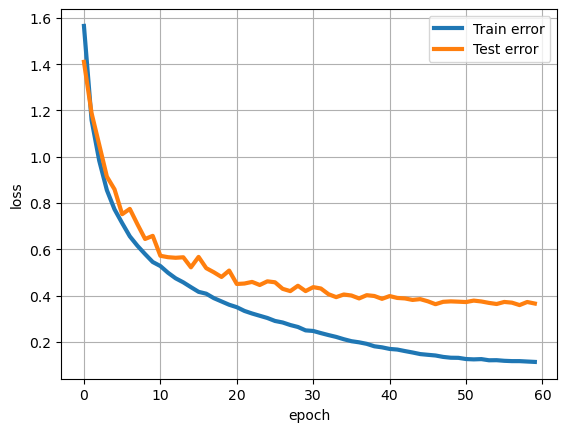

In [20]:
plt.plot(range(len(train_loss_history)),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(len(test_loss_history)),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.show()


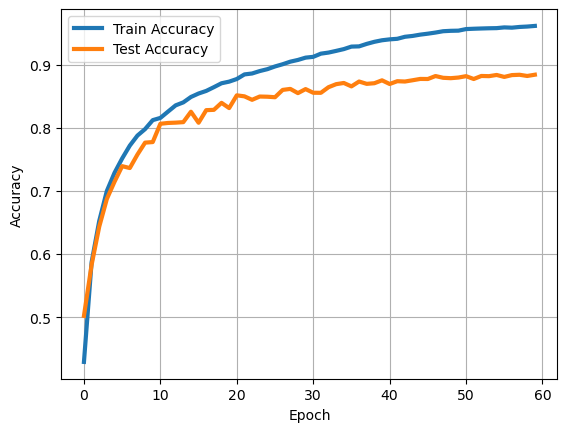

In [21]:
plt.plot(range(len(train_accuracy_history)),train_accuracy_history,'-',linewidth=3,label='Train Accuracy')
plt.plot(range(len(test_accuracy_history)),test_accuracy_history,'-',linewidth=3,label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

In [32]:
model.load_state_dict(torch.load('learn_rate_consistent_model.pth'))

<All keys matched successfully>

In [33]:
correct = 0
total = 0
model.eval()
for data in testDataLoader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    with torch.no_grad():
        predicted_output = model(images)
        _, predicted = torch.max(predicted_output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print('Accuracy of the network on the test images: %d %%' % (100 * accuracy))

Accuracy of the network on the test images: 92 %


In [22]:
def count_parameters(model):
    """
    Counts the number of trainable and non-trainable parameters in a PyTorch model.
    """
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = total_params - trainable_params
    
    print(f"Total parameters: {total_params}")
    print(f"Trainable parameters: {trainable_params}")
    print(f"Non-trainable parameters: {non_trainable_params}")

In [28]:
count_parameters(model)

Total parameters: 4903242
Trainable parameters: 4903242
Non-trainable parameters: 0


In [34]:
pip install nbconvert

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
